In [107]:
import pandas as pd
import numpy as np
from scipy.stats import t as t_distribution

In [108]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

from copy import deepcopy
import matplotlib as plt

# Prep: Generate population of YT users by subgroup

## Population

### Census: Subgroup population in USA (https://www.statista.com/statistics/241488/population-of-the-us-by-sex-and-age/)
For each subgroup of the US population, get the number of people

In [109]:
subgroup_pop = pd.read_csv('./subgroup_populations_census.txt', delimiter='\t')

In [110]:
# Data preprocessing
# Convert values to millions

subgroup_pop.iloc[0,0] = '0 to 5'
subgroup_pop.iloc[-1,0] = '85 to 100'
subgroup_pop['age_low'] = subgroup_pop['Age in years'].apply(
    lambda x: int(x[:x.index(' to ')])
)
subgroup_pop = subgroup_pop.iloc[:,1:]
subgroup_pop[['Male','Female']] = subgroup_pop[['Male','Female']].apply(lambda x: x*1000000)
subgroup_pop.rename(columns={'Male':'male','Female':'female'},inplace=True)

subgroup_pop.head()

,male,female,age_low
0,9620000.0,9200000.0,0
1,10380000.0,9920000.0,5
2,10990000.0,10460000.0,10
3,11020000.0,10540000.0,15
4,10970000.0,10550000.0,20


In [111]:
# Create upper_age category (e.g. 50+ or 65+)
upper = 65
dict_upper = subgroup_pop[subgroup_pop['age_low']>=upper].agg(sum)
dict_upper['age_low'] = upper
df_upper = pd.DataFrame(dict_upper).T

# Remove 18 and below people
dict_18 = subgroup_pop[subgroup_pop['age_low']==15].agg(sum) * 2/5
dict_18['age_low'] = 18
df_18 = pd.DataFrame(dict_18).T

subgroup_pop = subgroup_pop[(subgroup_pop['age_low']>=18) & (subgroup_pop['age_low']<upper)]
subgroup_pop = pd.concat([subgroup_pop, df_18, df_upper])
subgroup_pop.sort_values('age_low',inplace=True)
subgroup_pop

,male,female,age_low
0,4408000.0,4216000.0,18.0
4,10970000.0,10550000.0,20.0
5,11380000.0,11010000.0,25.0
6,11670000.0,11430000.0,30.0
7,11260000.0,11040000.0,35.0
8,10590000.0,10510000.0,40.0
9,9880000.0,9910000.0,45.0
10,10440000.0,10470000.0,50.0
11,10630000.0,10940000.0,55.0
12,10330000.0,10900000.0,60.0


In [112]:
# Make age bins
bin_size = 20
bins_list = [18] + list(range(25,66,bin_size))
bins_list = list(zip(bins_list,bins_list[1:]+[100]))
bins = pd.IntervalIndex.from_tuples(bins_list,closed='left')

subgroup_pop['age_bucket'] = pd.cut(subgroup_pop['age_low'],bins=bins)
subgroup_pop = subgroup_pop.groupby('age_bucket')['male','female'].agg('sum')

/var/folders/t6/srtzy2f51db8mxxv7g_63f6h0000gr/T/ipykernel_36107/1604408178.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  subgroup_pop = subgroup_pop.groupby('age_bucket')['male','female'].agg('sum')


In [113]:
# More preprocessing
subgroup_pop=subgroup_pop[['male','female']]
subgroup_pop = subgroup_pop.stack(-1)
subgroup_pop = subgroup_pop.rename('population')
subgroup_pop.index.set_names(['age_bucket','sex'],inplace=True)

In [114]:
# Create dictionary mapping to unique categories
subgroup_df = subgroup_pop.to_frame().reset_index()
subgroup_df['cats_str'] = subgroup_df['age_bucket'].astype('str') + subgroup_df['sex']
cats = subgroup_df['cats_str'].unique()
cats_dict = dict(zip(cats, list(range(len(cats)))))

cats_dict

{'[18, 25)male': 0,
 '[18, 25)female': 1,
 '[25, 45)male': 2,
 '[25, 45)female': 3,
 '[45, 65)male': 4,
 '[45, 65)female': 5,
 '[65, 100)male': 6,
 '[65, 100)female': 7}

In [115]:
subgroup_df['type'] = subgroup_df['cats_str'].apply(lambda x: cats_dict[x])
subgroup_df[['type','population']].to_csv('./post_stratification/categories.csv')

### PEW: Social media usage, by subgroup (https://www.pewresearch.org/internet/2021/04/07/social-media-use-in-2021/)
For each subgroup, get the number of people that use YouTube

In [116]:
results = pd.read_csv('pew_core_survey_2021_results.csv')

In [117]:
# Set index to sex and age, find ratios of YT usage

results['age_bucket'] = pd.cut(results['age'],bins=bins)
results['sex'].replace({1:'male',2:'female'},inplace=True)
results[['sex','age','age_bucket','web1e']]

usage_ratios = results.groupby(['age_bucket','sex'])['web1e'].agg(
    lambda x: int(x.value_counts()[1]) / len(x)
)

usage_ratios = usage_ratios.dropna()
usage_ratios.rename('usage',inplace=True)

usage_ratios.head()

age_bucket  sex   
[18, 25)    female    0.954545
            male      0.956522
[25, 45)    female    0.915584
            male      0.938776
[45, 65)    female    0.884058
Name: usage, dtype: float64

### Social media ratios
Combine Census (subgroup_pop) and PEW (usage_ratios) data on subgroups to get the estimated number of Americans who use YouTube, by subgroup

In [118]:
subgroup_pop.head(30)

age_bucket  sex   
[18, 25)    male      15378000.0
            female    14766000.0
[25, 45)    male      44900000.0
            female    43990000.0
[45, 65)    male      41280000.0
            female    42220000.0
[65, 100)   male      25220000.0
            female    30640000.0
Name: population, dtype: float64

In [119]:
usage_ratios.head(20)

age_bucket  sex   
[18, 25)    female    0.954545
            male      0.956522
[25, 45)    female    0.915584
            male      0.938776
[45, 65)    female    0.884058
            male      0.847826
[65, 100)   female    0.599138
            male      0.579365
Name: usage, dtype: float64

In [120]:
# Find absolute number of people from each subgroup that use YT

# The values make sense
# For young folks there are more males bc the content is male-dominated. 
# For older folks it reflects more of the general us pop.

usage_pops = pd.DataFrame(usage_ratios).join(subgroup_pop)

yt_usage_abs = usage_pops['usage'] * usage_pops['population']
yt_usage_abs.rename('yt_usage_abs',inplace=True)

age_bucket  sex   
[18, 25)    female    1.409482e+07
            male      1.470939e+07
[25, 45)    female    4.027656e+07
            male      4.215102e+07
[45, 65)    female    3.732493e+07
            male      3.499826e+07
[65, 100)   female    1.835759e+07
            male      1.461159e+07
Name: yt_usage_abs, dtype: float64

### [12/6] Map subgroups to a number category (or "type")

In [121]:
cats_dict

{'[18, 25)male': 0,
 '[18, 25)female': 1,
 '[25, 45)male': 2,
 '[25, 45)female': 3,
 '[45, 65)male': 4,
 '[45, 65)female': 5,
 '[65, 100)male': 6,
 '[65, 100)female': 7}

In [122]:
yt_usage_abs_df = yt_usage_abs.to_frame()
yt_usage_abs_df.reset_index(inplace=True)
yt_usage_abs_df['type'] = (
    yt_usage_abs_df['age_bucket'].astype('str') +
    yt_usage_abs_df['sex'].astype('str')
).apply(lambda x: cats_dict[x])

yt_usage_abs_2 = yt_usage_abs_df[['yt_usage_abs','type']].set_index('type')
yt_usage_abs_2

,yt_usage_abs
type,
1,1.409482e+07
0,1.470939e+07
3,4.027656e+07
2,4.215102e+07
5,3.732493e+07
4,3.499826e+07
7,1.835759e+07
6,1.461159e+07


# Get responses from survey respondents

In [123]:
buttons = ['delete','dislike','not_int','no_chan']

In [124]:
qs = {
    'Q32': 'prolific_id',
    'Q16': 'experience',
    'Q92': 'attention_1',
    'Q95': 'attention_2',
    'Q97': 'attention_3'
}

button_qs = {
    'Q23': 'delete_aware',
    'Q24': 'delete_use_real',
    'Q26' : 'delete_use_hyp',
    'Q25' : 'delete_eff_real',
    'Q27' : 'delete_eff_hyp',
    
    'Q60': 'dislike_aware',
    'Q61': 'dislike_use_real',
    'Q62' : 'dislike_use_hyp',
    'Q63' : 'dislike_eff_real',
    'Q64' : 'dislike_eff_hyp',
    
    'Q67': 'not_int_aware',
    'Q68': 'not_int_use_real',
    'Q69' : 'not_int_use_hyp',
    'Q71' : 'not_int_eff_real',
    'Q72' : 'not_int_eff_hyp',
    
    'Q81': 'no_chan_aware',
    'Q82': 'no_chan_use_real',
    'Q83' : 'no_chan_use_hyp',
    'Q85' : 'no_chan_eff_real',
    'Q86' : 'no_chan_eff_hyp'    
}

qs.update(button_qs)

In [125]:
survey = pd.read_csv('./yt_disinterest_survey_results.csv')
survey = survey.rename(
    columns=qs
)

In [126]:
# rows of interest
# only get prolific_id-looking survey rows
survey.dropna(subset=['prolific_id'])
sample_pid = '610c250a4cf53941b3e3e55d'
survey.astype({'prolific_id':'object'})
survey['has_id']=survey['prolific_id'].apply(
    lambda x: len(str(x))==len(sample_pid)
)

survey=survey[survey['has_id']]
# column header rows
survey = survey.iloc[2:,:]

In [127]:
# attention checks
survey = survey[
    (survey['attention_1'] == '2') &
    (survey['attention_2'] == 'Yes') &
    (survey['attention_3'].isin(['video','Video']))
]

In [128]:
# columns of interest
survey = survey[list(qs.values())]
for att_idx in [1,2,3]:
    survey = survey.loc[:, survey.columns !='attention_{0}'.format(att_idx)]

# set index
survey.set_index('prolific_id',inplace=True)

# replace values
survey.replace({'Yes':1, 
                'Yes, sometimes': 1,
                'Yes, rarely': 1,
                'Yes, very frequently': 1,
                'Never': 0,
                'No':0, 
                'Not sure':pd.NA,
                '5- completely effective': 5,
                '1- not at all effective': 1
               }, inplace=True)

# change value types
for c in survey.columns:
    survey[c] = pd.to_numeric(survey[c])
survey = survey.astype('Int64')

In [129]:
survey.shape

(274, 21)

In [130]:
# add more columns of interest
for b in buttons:
    survey['{0}_exp_aware'.format(b)] = (survey['experience'] * survey['{0}_aware'.format(b)]).replace({0:pd.NA})

    # [1/13] Hacky way of quickly getting aware given experience 
    survey['{0}_aware__exp'.format(b)] = survey['experience'].replace({0:pd.NA}) * survey['{0}_aware'.format(b)]
    
    survey['{0}_use__exp_aware'.format(b)] = survey['{0}_use_real'.format(b)] * survey['{0}_exp_aware'.format(b)]
    survey['{0}_eff__exp_aware_use'.format(b)] = survey['{0}_eff_real'.format(b)] * (survey['{0}_exp_aware'.format(b)] * survey['{0}_use_real'.format(b)]).replace({0:pd.NA})
    survey['{0}_eff__exp_aware_no_use'.format(b)] = survey['{0}_eff_hyp'.format(b)] * (survey['{0}_exp_aware'.format(b)] * survey['{0}_use_real'.format(b)]).replace({1:pd.NA, 0:1})
    survey['{0}_eff__exp_aware'.format(b)] = (survey['{0}_eff__exp_aware_use'.format(b)].replace({pd.NA:0}) + survey['{0}_eff__exp_aware_no_use'.format(b)].replace({pd.NA:0})).replace({0:pd.NA})


In [131]:
#sanity check
assert(survey['no_chan_eff__exp_aware_no_use'].sum() == 
       survey[(survey['experience']==1)&(survey['no_chan_aware']==1)&(survey['no_chan_use_real']==0)]['no_chan_eff_hyp'].sum()
      )
       

In [132]:
# Join with Prolific's demographics data

survey_dems=pd.read_csv('./prolific_demographics.csv')
survey_dems = survey_dems[['Participant id', 'Age', 'Sex']]
survey_dems.set_index('Participant id', inplace=True)
survey_dems.head()

survey = survey.join(survey_dems)

In [133]:
# Change index to sex and age_bucket
survey['age_bucket'] = pd.cut(survey['Age'],bins=bins)
# Keep only binary genders
survey = survey[survey['Sex'].isin(['Male','Female'])]
survey['Sex'].replace({g:g.lower() for g in ['Male','Female']},inplace=True)

# Change each subgroup to a type number 
survey['cats_str'] = survey['age_bucket'].astype('str') + survey['Sex']
survey['type'] = survey['cats_str'].apply(lambda x: cats_dict[x])

In [134]:
survey.head()

,experience,delete_aware,delete_use_real,delete_use_hyp,delete_eff_real,delete_eff_hyp,dislike_aware,dislike_use_real,dislike_use_hyp,dislike_eff_real,...,no_chan_aware__exp,no_chan_use__exp_aware,no_chan_eff__exp_aware_use,no_chan_eff__exp_aware_no_use,no_chan_eff__exp_aware,Age,Sex,age_bucket,cats_str,type
prolific_id,,,,,,,,,,,,,,,,,,,,,
61084e45d53567348ae45e57,1,0,0,<NA>,<NA>,<NA>,1,0,<NA>,<NA>,...,0,<NA>,<NA>,<NA>,<NA>,46.0,female,"[45, 65)","[45, 65)female",5
5ec3884fa0c1ef0009b57549,1,0,0,<NA>,<NA>,<NA>,1,0,<NA>,<NA>,...,1,0,<NA>,4,4,25.0,female,"[25, 45)","[25, 45)female",3
5f51667a8dff8f39dba7df7f,1,<NA>,0,<NA>,<NA>,4,1,1,<NA>,5,...,0,<NA>,<NA>,<NA>,<NA>,35.0,male,"[25, 45)","[25, 45)male",2
5ed856ab1f4a23368be98b1a,1,1,0,<NA>,<NA>,3,1,1,<NA>,1,...,1,1,4,<NA>,4,21.0,female,"[18, 25)","[18, 25)female",1
5f3ae1d68c88967a1d3b86c0,1,1,0,<NA>,<NA>,3,1,<NA>,<NA>,<NA>,...,1,1,4,<NA>,4,27.0,male,"[25, 45)","[25, 45)male",2


## Run survey diagnostics
How does our survey sample differ from estimated YT using population?

In [136]:
# the frequency of each subgroup, 
#   for the sample that answered each question as well as the estimated YT using population    
bq_pop_list=[]

qs_list = []
for b in buttons:
    for q in ['aware','aware__exp','use__exp_aware','eff__exp_aware','eff__exp_aware_use','eff__exp_aware_no_use']:
        qs_list.append('{0}_{1}'.format(b,q))

for bq in qs_list:
    bq_pop_list.append(
        survey[~survey[bq].isna()]['type'].value_counts(normalize=True).rename(bq)
    )
bq_pop = pd.concat(bq_pop_list,axis=1).join(yt_usage_abs_2.apply(lambda x: x / x.sum()))


In [137]:
# Get totals, rearrange rows and columns, na --> 0
bq_pop_sums = bq_pop.sum().rename('total')
bq_pop.replace({np.nan:0}, inplace=True)
bq_pop = bq_pop.loc[list(range(len(cats_dict.keys()))),:]
bq_pop.index = list(cats_dict.keys())

In [138]:
# for heatmap
bq_pop_float = deepcopy(bq_pop)
bq_pop_float = bq_pop_float.loc[
    list(cats_dict.keys()),['yt_usage_abs']+qs_list
]

<AxesSubplot:>

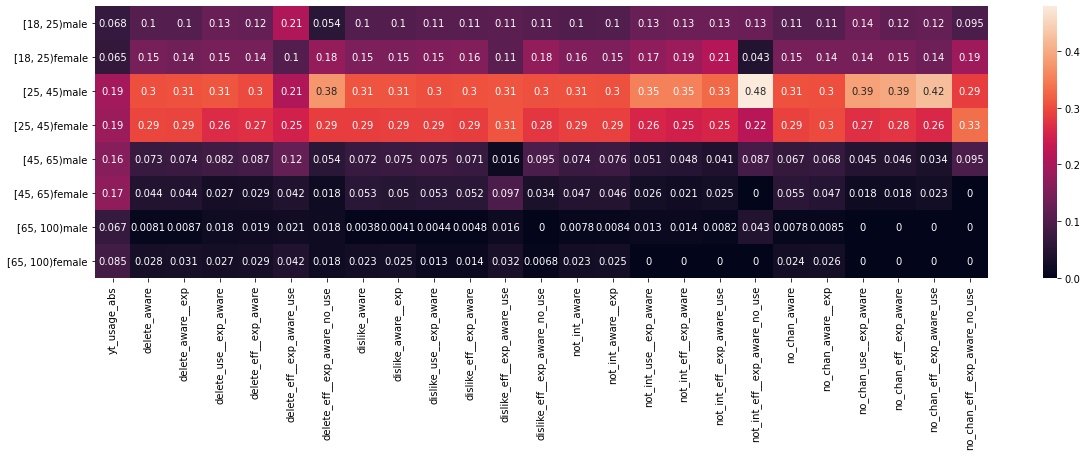

In [139]:
fig, ax = plt.pyplot.subplots(figsize=(20,5))         # Sample figsize in inches

sns.heatmap(bq_pop_float, annot=True)

In [140]:
# Percentage printouts with totals
bq_pop = bq_pop.apply(
    lambda x: x.apply(lambda y: '{0:.2f}%'.format(y*100))
)
bq_pop.append(bq_pop_sums).loc[
    list(cats_dict.keys())+['total'],['yt_usage_abs']+qs_list
]

/var/folders/t6/srtzy2f51db8mxxv7g_63f6h0000gr/T/ipykernel_36107/2726684950.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bq_pop.append(bq_pop_sums).loc[


,yt_usage_abs,delete_aware,delete_aware__exp,delete_use__exp_aware,delete_eff__exp_aware,delete_eff__exp_aware_use,delete_eff__exp_aware_no_use,dislike_aware,dislike_aware__exp,dislike_use__exp_aware,...,not_int_use__exp_aware,not_int_eff__exp_aware,not_int_eff__exp_aware_use,not_int_eff__exp_aware_no_use,no_chan_aware,no_chan_aware__exp,no_chan_use__exp_aware,no_chan_eff__exp_aware,no_chan_eff__exp_aware_use,no_chan_eff__exp_aware_no_use
"[18, 25)male",6.79%,10.48%,10.48%,12.73%,12.50%,20.83%,5.36%,10.27%,10.37%,11.06%,...,12.82%,13.10%,13.11%,13.04%,10.59%,10.64%,13.51%,11.93%,12.50%,9.52%
"[18, 25)female",6.51%,14.52%,13.97%,14.55%,14.42%,10.42%,17.86%,15.21%,14.94%,15.49%,...,17.31%,18.62%,21.31%,4.35%,14.51%,14.47%,14.41%,14.68%,13.64%,19.05%
"[25, 45)male",19.47%,30.24%,30.57%,30.91%,29.81%,20.83%,37.50%,30.80%,30.71%,30.09%,...,35.26%,35.17%,32.79%,47.83%,30.59%,30.21%,38.74%,39.45%,42.05%,28.57%
"[25, 45)female",18.60%,29.44%,29.26%,26.36%,26.92%,25.00%,28.57%,28.52%,28.63%,28.76%,...,25.64%,24.83%,25.41%,21.74%,29.02%,29.79%,27.03%,27.52%,26.14%,33.33%
"[45, 65)male",16.16%,7.26%,7.42%,8.18%,8.65%,12.50%,5.36%,7.22%,7.47%,7.52%,...,5.13%,4.83%,4.10%,8.70%,6.67%,6.81%,4.50%,4.59%,3.41%,9.52%
"[45, 65)female",17.24%,4.44%,4.37%,2.73%,2.88%,4.17%,1.79%,5.32%,4.98%,5.31%,...,2.56%,2.07%,2.46%,0.00%,5.49%,4.68%,1.80%,1.83%,2.27%,0.00%
"[65, 100)male",6.75%,0.81%,0.87%,1.82%,1.92%,2.08%,1.79%,0.38%,0.41%,0.44%,...,1.28%,1.38%,0.82%,4.35%,0.78%,0.85%,0.00%,0.00%,0.00%,0.00%
"[65, 100)female",8.48%,2.82%,3.06%,2.73%,2.88%,4.17%,1.79%,2.28%,2.49%,1.33%,...,0.00%,0.00%,0.00%,0.00%,2.35%,2.55%,0.00%,0.00%,0.00%,0.00%
total,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## [12/6] Get stata file for post-stratification
Stata requires survey sample with (1) type (i.e. the category for post-strat) and (2) the number of the type in the population.

In [141]:
survey_cats = survey.join(yt_usage_abs_2, on='type')

In [142]:
survey_cats.head()

,experience,delete_aware,delete_use_real,delete_use_hyp,delete_eff_real,delete_eff_hyp,dislike_aware,dislike_use_real,dislike_use_hyp,dislike_eff_real,...,no_chan_use__exp_aware,no_chan_eff__exp_aware_use,no_chan_eff__exp_aware_no_use,no_chan_eff__exp_aware,Age,Sex,age_bucket,cats_str,type,yt_usage_abs
prolific_id,,,,,,,,,,,,,,,,,,,,,
61084e45d53567348ae45e57,1,0,0,<NA>,<NA>,<NA>,1,0,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,46.0,female,"[45, 65)","[45, 65)female",5,3.732493e+07
5ec3884fa0c1ef0009b57549,1,0,0,<NA>,<NA>,<NA>,1,0,<NA>,<NA>,...,0,<NA>,4,4,25.0,female,"[25, 45)","[25, 45)female",3,4.027656e+07
5f51667a8dff8f39dba7df7f,1,<NA>,0,<NA>,<NA>,4,1,1,<NA>,5,...,<NA>,<NA>,<NA>,<NA>,35.0,male,"[25, 45)","[25, 45)male",2,4.215102e+07
5ed856ab1f4a23368be98b1a,1,1,0,<NA>,<NA>,3,1,1,<NA>,1,...,1,4,<NA>,4,21.0,female,"[18, 25)","[18, 25)female",1,1.409482e+07
5f3ae1d68c88967a1d3b86c0,1,1,0,<NA>,<NA>,3,1,<NA>,<NA>,<NA>,...,1,4,<NA>,4,27.0,male,"[25, 45)","[25, 45)male",2,4.215102e+07


In [143]:
survey_cats['yt_usage_abs'] = survey_cats['yt_usage_abs'].astype('int')
survey_cats['n_pop'] = [int(yt_usage_abs_2.sum()[0]) for i in range(survey_cats.shape[0])]
survey_cats.rename(columns={'yt_usage_abs':'n_type'},inplace=True)

In [144]:
survey_cats.to_stata('./post_stratification/sex_age_{0}.dta'.format(bin_size), write_index=False)

# ^ This gives a warning, which I've checked is fine in Stata
# Basically, it's confirmed that NA is registered in Stata and not used in mean calculations


/Users/avliu/opt/anaconda3/envs/scrub-analysis/lib/python3.10/site-packages/pandas/io/stata.py:698: ValueLabelTypeMismatch: 
Stata value labels (pandas categories) must be strings. Column age_bucket contains
non-string labels which will be converted to strings.  Please check that the
Stata data file created has not lost information due to duplicate labels.

  warnings.warn(


### [12/10] Get counts 

In [145]:
survey_n=survey_cats[qs_list].apply(lambda x: len(x) - x.isna().sum()).rename('n')
survey_n

delete_aware                     248
delete_aware__exp                229
delete_use__exp_aware            110
delete_eff__exp_aware            104
delete_eff__exp_aware_use         48
delete_eff__exp_aware_no_use      56
dislike_aware                    263
dislike_aware__exp               241
dislike_use__exp_aware           226
dislike_eff__exp_aware           210
dislike_eff__exp_aware_use        62
dislike_eff__exp_aware_no_use    148
not_int_aware                    258
not_int_aware__exp               237
not_int_use__exp_aware           156
not_int_eff__exp_aware           145
not_int_eff__exp_aware_use       122
not_int_eff__exp_aware_no_use     23
no_chan_aware                    255
no_chan_aware__exp               235
no_chan_use__exp_aware           111
no_chan_eff__exp_aware           109
no_chan_eff__exp_aware_use        88
no_chan_eff__exp_aware_no_use     21
Name: n, dtype: int64

In [146]:
survey_n.to_csv('./survey_sample_size.csv')

# Perform post-stratification
Update: bug SOLVED (didn't drop subgroups for which no sample data exists, also didn't report ratio right when ONLY Yes' were reported. The result was extreme underestimation)

This is old and unused... from when I thought I could do it by hand but was advised against it by statistics consulatants. It's still useful to cross-reference with Stata results, though

In [147]:
survey

,experience,delete_aware,delete_use_real,delete_use_hyp,delete_eff_real,delete_eff_hyp,dislike_aware,dislike_use_real,dislike_use_hyp,dislike_eff_real,...,no_chan_aware__exp,no_chan_use__exp_aware,no_chan_eff__exp_aware_use,no_chan_eff__exp_aware_no_use,no_chan_eff__exp_aware,Age,Sex,age_bucket,cats_str,type
prolific_id,,,,,,,,,,,,,,,,,,,,,
61084e45d53567348ae45e57,1,0,0,<NA>,<NA>,<NA>,1,0,<NA>,<NA>,...,0,<NA>,<NA>,<NA>,<NA>,46.0,female,"[45, 65)","[45, 65)female",5
5ec3884fa0c1ef0009b57549,1,0,0,<NA>,<NA>,<NA>,1,0,<NA>,<NA>,...,1,0,<NA>,4,4,25.0,female,"[25, 45)","[25, 45)female",3
5f51667a8dff8f39dba7df7f,1,<NA>,0,<NA>,<NA>,4,1,1,<NA>,5,...,0,<NA>,<NA>,<NA>,<NA>,35.0,male,"[25, 45)","[25, 45)male",2
5ed856ab1f4a23368be98b1a,1,1,0,<NA>,<NA>,3,1,1,<NA>,1,...,1,1,4,<NA>,4,21.0,female,"[18, 25)","[18, 25)female",1
5f3ae1d68c88967a1d3b86c0,1,1,0,<NA>,<NA>,3,1,<NA>,<NA>,<NA>,...,1,1,4,<NA>,4,27.0,male,"[25, 45)","[25, 45)male",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5dce3ccc32ccbf0cd54263db,1,0,0,<NA>,<NA>,3,1,1,<NA>,5,...,1,1,4,<NA>,4,23.0,female,"[18, 25)","[18, 25)female",1
5eace152e25d6800091dd418,1,0,0,<NA>,<NA>,<NA>,1,0,<NA>,<NA>,...,1,<NA>,<NA>,<NA>,<NA>,43.0,female,"[25, 45)","[25, 45)female",3
5d1b0776e1c05200018b582d,0,1,<NA>,1,<NA>,4,1,<NA>,1,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,34.0,female,"[25, 45)","[25, 45)female",3


In [148]:
# Percentage of a series with 1 (discounting NA's)
def ratio_yes(series):
    num_1 = (series==1).sum()
    num_0 = (series==0).sum()
    
    if num_0 + num_1 == 0:            
        return pd.NA
    elif num_0 == 0:
        return 1
    else:
        return num_1 / (num_0 + num_1)

# Don't use provided std. Instead, use Bernouli std calculation
def std(series):
    # return series.std()
    r = ratio_yes(series)
    return np.sqrt(r * (1-r))

In [149]:
survey_buckets = survey.groupby(['age_bucket','Sex']).agg([ratio_yes, 'count'])
survey_buckets.index.rename(['age_bucket','sex'],inplace=True)

In [150]:
survey_buckets.head(20)

experience       delete_aware       delete_use_real        \
                   ratio_yes count    ratio_yes count       ratio_yes count   
age_bucket sex                                                                
[18, 25)   female   0.900000    40     0.555556    36        0.187500    32   
           male     0.925926    27     0.576923    26        0.440000    25   
[25, 45)   female   0.921053    76     0.493151    73        0.200000    65   
           male     0.914634    82     0.546667    75        0.188406    69   
[45, 65)   female   0.800000    15     0.272727    11        0.181818    11   
           male     0.947368    19     0.555556    18        0.352941    17   
[65, 100)  female   1.000000     7     0.428571     7        0.333333     6   
           male     1.000000     2     1.000000     2        0.500000     2   

                  delete_use_hyp       delete_eff_real        ...  \
                       ratio_yes count       ratio_yes count  ...   
age_bucket sex                                                ...   
[18, 25)   female              1     2            <NA>     5  ...   
           male                0     2            <NA>    10  ...   
[25, 45)   female              1     6               1    12  ...   
           male                1     7            <NA>    11  ...   
[45, 65)   female           <NA>     0            <NA>     2  ...   
           male                1     1            <NA>     6  ...   
[65, 100)  female           <NA>     0            <NA>     2  ...   
           male             <NA>     0            <NA>     1  ...   

                  no_chan_eff__exp_aware_no_use       no_chan_eff__exp_aware  \
                                      ratio_yes count              ratio_yes   
age_bucket sex                                                                 
[18, 25)   female                          <NA>     4                   <NA>   
           male                            <NA>     2                      1   
[25, 45)   female                          <NA>     7                   <NA>   
           male                               1     6                      1   
[45, 65)   female                          <NA>     0                   <NA>   
           male                            <NA>     2                   <NA>   
[65, 100)  female                          <NA>     0                   <NA>   
           male                            <NA>     0                   <NA>   

                              Age        cats_str            type        
                  count ratio_yes count ratio_yes count ratio_yes count  
age_bucket sex                                                           
[18, 25)   female    16      <NA>    40      <NA>    40         1    40  
           male      13      <NA>    27      <NA>    27       0.0    27  
[25, 45)   female    30      <NA>    76      <NA>    76      <NA>    76  
           male      43      <NA>    82      <NA>    82      <NA>    82  
[45, 65)   female     2      <NA>    15      <NA>    15      <NA>    15  
           male       5      <NA>    19      <NA>    19      <NA>    19  
[65, 100)  female     0      <NA>     7      <NA>     7      <NA>     7  
           male       0      <NA>     2      <NA>     2      <NA>     2  

[8 rows x 96 columns]

In [151]:
test = survey_buckets['dislike_aware'].join(yt_usage_abs.rename('N'))
test['N_r'] = test['N']/sum(test['N'])

In [152]:
test

ratio_yes  count             N       N_r
age_bucket sex                                             
[18, 25)   female   1.000000     40  1.409482e+07  0.065096
           male     1.000000     27  1.470939e+07  0.067934
[25, 45)   female   0.986667     75  4.027656e+07  0.186014
           male     0.962963     81  4.215102e+07  0.194671
[45, 65)   female   1.000000     14  3.732493e+07  0.172382
           male     0.947368     19  3.499826e+07  0.161637
[65, 100)  female   0.500000      6  1.835759e+07  0.084783
           male     1.000000      1  1.461159e+07  0.067482

In [153]:
test.dropna()

ratio_yes  count             N       N_r
age_bucket sex                                             
[18, 25)   female   1.000000     40  1.409482e+07  0.065096
           male     1.000000     27  1.470939e+07  0.067934
[25, 45)   female   0.986667     75  4.027656e+07  0.186014
           male     0.962963     81  4.215102e+07  0.194671
[45, 65)   female   1.000000     14  3.732493e+07  0.172382
           male     0.947368     19  3.499826e+07  0.161637
[65, 100)  female   0.500000      6  1.835759e+07  0.084783
           male     1.000000      1  1.461159e+07  0.067482

In [154]:
test['ratio_yes'].replace({pd.NA:0})

age_bucket  sex   
[18, 25)    female    1.000000
            male      1.000000
[25, 45)    female    0.986667
            male      0.962963
[45, 65)    female    1.000000
            male      0.947368
[65, 100)   female    0.500000
            male      1.000000
Name: ratio_yes, dtype: float64

In [155]:
sum(test['ratio_yes'].replace({pd.NA:0}) * test['N_r'])

0.9394110241213519

In [156]:
results_list = []

# Perform post-stratification
for b in buttons:
    temp_df = survey_buckets[b+'_aware'].join(yt_usage_abs.rename('N')).dropna()
    # Printing confirms that for every age bucket of survey respondents, we know their absolute number
    # In retrospect, let's cutoff at 18 below and do 65+ category for above
    #print(temp_df)
    
    temp_df.rename(columns={
        'ratio_yes': 'y_bar',
    }, inplace=True)
    
    # Calculate population ratios 
    temp_df['N_ratio'] = temp_df['N'] / sum(temp_df['N'])
    
    #print(temp_df)
    # make sure ratios add to 1
    assert(abs(1-temp_df['N_ratio'].sum()) < 0.00001)
    new_usage_ratio = sum(temp_df['y_bar'].replace({pd.NA:0}) * temp_df['N_ratio'])
    old_usage_ratio = ratio_yes(survey[b+'_aware'])

    print('{0}: {1:.2f}% ({2:.2f}%)'.format(b+'_aware',new_usage_ratio*100,old_usage_ratio*100))
    
    results_list.append({
        'button': b,
        'y_ps': new_usage_ratio,
        'y_old': old_usage_ratio,
    })

delete_aware: 51.41% (52.42%)
dislike_aware: 93.94% (96.96%)
not_int_aware: 56.03% (66.28%)
no_chan_aware: 35.37% (49.02%)


In [157]:
results_df = pd.DataFrame(results_list)
results_df[['button','y_ps','y_old']].head()

,button,y_ps,y_old
0,delete,0.514140,0.524194
1,dislike,0.939411,0.969582
2,not_int,0.560274,0.662791
3,no_chan,0.353651,0.490196
